# Testing generative framework on incomplete data

This jupyter notebook is to test different arrangement / emission models fitting on incomplete data. The main porpuse of this short example is trying to show the generativ framework is able to provide an elegent solution when dealing with missing dataset via an EM procedure.

<br>

## Generate true data from markov random field

First, we generate some true individual parcellations $U$s given by a prior. We can fine-tuning the parameters to control how smooth the parcel boundaries are and the individual variablities.

<br>

In [1]:
# dependencies
%load_ext autoreload
%autoreload 2 
import os
import sys 
sys.path.append(os.path.abspath('..'))

import numpy as np
import torch as pt
import matplotlib.pyplot as plt

from full_model import FullModel
import emissions as em
import arrangements as ar
import spatial as sp

### Plotting the group prior

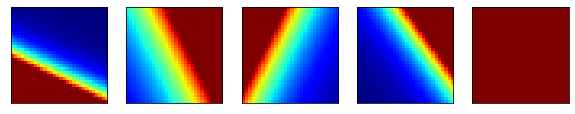

In [10]:
K=5
N=20
num_sub=10
max_iter=100
sigma2=0.2
missingdata=0.2
width = 30
height = 30

# Step 1: Create the true model
grid = sp.SpatialGrid(width=width, height=height)
arrangeT = ar.PottsModel(grid.W, K=K)
emissionT = em.MixGaussian(K=K, N=N, P=grid.P, std_V=False)
emissionT.sigma2 = pt.tensor(sigma2)

# Step 2: Initialize the parameters of the true model
arrangeT.random_smooth_pi(grid.Dist, theta_mu=150)
arrangeT.theta_w = pt.tensor(20)

# Step 3: Plot the prior of the true mode
plt.figure(figsize=(10, 4))
grid.plot_maps(pt.exp(arrangeT.logpi), cmap='jet', vmax=1, grid=[1, K])

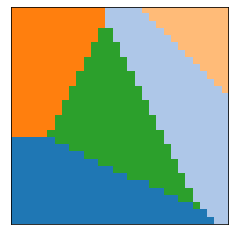

In [11]:
cluster = np.argmax(arrangeT.logpi, axis=0)
grid.plot_maps(cluster, cmap='tab20')

### Sample true individual parcellations

Here, we generate the true individual parcellations for 10 subjects given by the group prior. In our simulation, we make the boundaries relatively smooth and more individual varibilities.

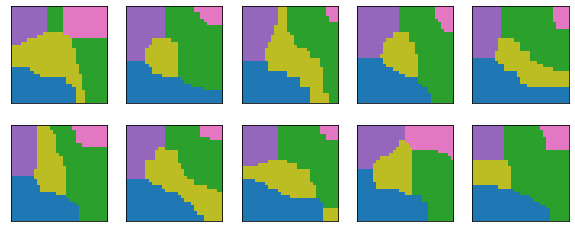

In [12]:
# Step 4: Generate data by sampling from the above model
T = FullModel(arrangeT, emissionT)
U = T.arrange.sample(num_subj=num_sub, burnin=30)
Y_train = T.emission.sample(U)
Y_test = T.emission.sample(U)

plt.figure(figsize=(10, 4))
grid.plot_maps(U[0:10], cmap='tab20', vmax=K, grid=[2, int(num_sub/2)])

### Generate Incomplete data

Here, we add some missing regions to mimic the voxel data missing in the real dataset. In general, the missing data happens as a contiguous (voxel) area. It coud be only few or many regions (voxels) data missing. So the `missingdata` is the precentage of the missing voxels.

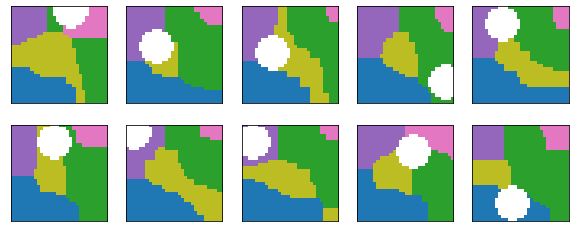

In [21]:
missingdata = 0.1

radius = np.sqrt(missingdata * grid.P/np.pi)
centroid = np.random.choice(grid.P, (num_sub,))
mask = pt.ones(num_sub, grid.P)
mask[pt.where(grid.Dist[centroid] < radius)] = pt.nan
Y_train = mask.unsqueeze(1) * Y_train

plt.figure(figsize=(10, 4))
grid.plot_maps(mask * U, cmap='tab20', vmax=K, grid=[2, int(num_sub / 2)])

### Fitting the Incomplete data to the generative model

Now, we use these incomplete data to fit our generative model, in the hope of mimicing the situation when fitting the real data.

In [22]:
# Step 6: Generate new models for fitting
# arrangeM = ar.PottsModel(grid.W, K=K)
arrangeM = ar.ArrangeIndependent(K=K, P=grid.P, spatial_specific=True, remove_redundancy=False)
emissionM = em.MixGaussian(K=K, N=N, P=grid.P, std_V=False)
M = FullModel(arrangeM, emissionM)
M, ll, theta, Uhat_fit = M.fit_em(Y=Y_train, iter=200, tol=0.00001, fit_arrangement=True)

<AxesSubplot:title={'center':'True/estimated log sigma2'}>

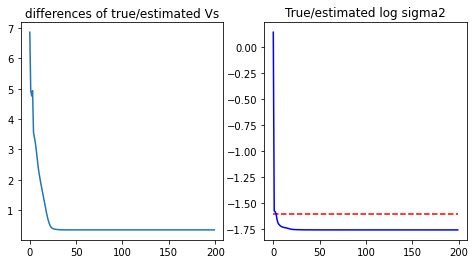

In [23]:
from simulate_missingData import matching_params, _plot_diff, _plt_single_param_diff

# Step 7: Plot fitting results
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# _plot_loglike(axs[0], ll, loglike_true, color='b')

true_V = T.emission.V
predicted_V = theta[:, M.get_param_indices('emission.V')]
idx = matching_params(true_V, predicted_V, once=False)
_plot_diff(axs[0], true_V, predicted_V, index=idx, name='V', plot_single=True)

ind = M.get_param_indices('emission.sigma2')
_plt_single_param_diff(axs[1], np.log(T.emission.sigma2), np.log(theta[:, ind]), name='log sigma2')

### Visualization of model recovery results

Now, we plot the fitted $\hat{U}$ for the individuals and see how good the generative model handles the missing data.

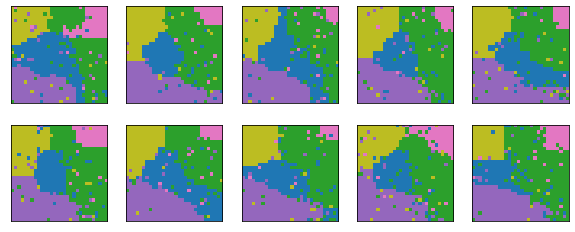

In [24]:
plt.figure(figsize=(10, 4))
grid.plot_maps(pt.argmax(Uhat_fit, dim=1), cmap='tab20', vmax=K, grid=[2, int(num_sub / 2)])

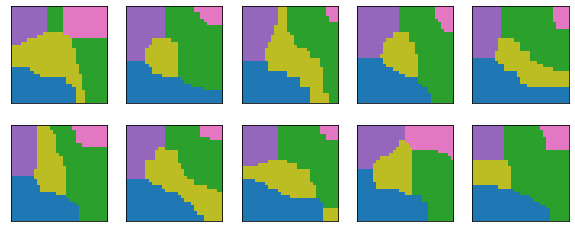

In [25]:
plt.figure(figsize=(10, 4))
grid.plot_maps(U[0:10], cmap='tab20', vmax=K, grid=[2, int(num_sub/2)])